In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

# Import Module

In [2]:
# torch module
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
# np panda matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# other
import time
import copy
from tqdm import tqdm,tqdm_notebook

# Global Variance

In [3]:
# CPU/GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# label/unlabel root_dir
label_dir, unlabel_dir = '/kaggle/input/training/training', '/kaggle/input/unknown'
# label_dir, unlabel_dir = 'raw/training', 'raw/unknown'

BATCH_SIZE=4 # a batch pic num
MEAN=np.array([0.485, 0.456, 0.406]) # standarize mean
STD=np.array([0.229, 0.224, 0.225]) # standarize std


# data_transform: PIL 2 Tensor
data_transform = transforms.Compose([
    transforms.Resize(300),# Resize for unsample
    transforms.CenterCrop(224), #CenterCrop for remove edge pixels(not-important)
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])


# Read Data

In [4]:
#  Read labeled data by ImageFolder (train and val)
all_labeled = datasets.ImageFolder(label_dir, data_transform)
class_names = all_labeled.classes  # all class name [fake,real]

#  Read labeled data by ImageFolder (test)
all_unlabeled = datasets.ImageFolder(unlabel_dir, data_transform)



def generate_dataloader(train_pct=0.9):
    '''random split all_labeled data by train_pct, return 
    @dataloaders dict of train/val dataloader
    @dataset_sizes dict of train/val length'''
    global all_labeled
    train_size = int(len(all_labeled) * train_pct)
    val_size = len(all_labeled) - train_size

    image_datasets = {}
    image_datasets['train'], image_datasets['val'] = torch.utils.data.random_split(
        all_labeled, [train_size, val_size])
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                                  shuffle=True, num_workers=4)
                   for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

    return dataloaders, dataset_sizes


# Visualize Some Data

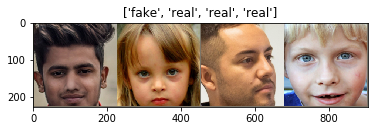

In [5]:
# get a batch tensor
dataloaders, dataset_sizes = generate_dataloader()

# show a batch img
inp, classes = next(iter(dataloaders['train']))
inp = torchvision.utils.make_grid(inp)
inp = inp.numpy().transpose((1, 2, 0))
inp = inp * STD + MEAN
inp = np.clip(inp, 0, 1) # value can not bigger than 1 
plt.imshow(inp)
plt.title([class_names[ci] for ci in classes])
plt.show()

# Model Train

METHOD: fine-tune a pretrained resnet18 model 

In [6]:
# params of training

# load pretrained resnet18 model
model = models.resnet18(pretrained=True)
fc_in_num = model.fc.in_features
# reset fc layer weight
model.fc = nn.Linear(fc_in_num, 2)
model = model.to(device) # CPU/GPU model

# loss function(CrossEntropyLoss)
criterion = nn.CrossEntropyLoss() 
# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# scheduler of optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 93940109.88it/s]


In [7]:
EPOCH_NUM=25 # epoch of train (can tune)
TRAIN_PCT=0.9 # train data size percent (can tune)

# # each epoch split data again(no)
# dataloaders, dataset_sizes = generate_dataloader(train_pct=TRAIN_PCT)

TIME_START = time.time()
best_params = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(EPOCH_NUM):

    # each epoch split data again(yes,model see more data)
    dataloaders, dataset_sizes = generate_dataloader(train_pct=TRAIN_PCT)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            scheduler.step()
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in tqdm(dataloaders[phase],desc='Epoch: %d/%d(%s)'%(epoch+1,EPOCH_NUM,phase)):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('Loss: %.3f Acc: %.3f'%(epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_params = copy.deepcopy(model.state_dict())
            
    if best_acc>=1:
        break


TIME_COST= time.time() - TIME_START

print('Training complete!'.center(30, '-'))
print('Time elapsed: %dm %ds'%(TIME_COST // 60, TIME_COST % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Epoch: 1/25(val):   0%|          | 0/34 [00:00<?, ?it/s]

Loss: 0.835 Acc: 0.608


Epoch: 2/25(train):   0%|          | 0/305 [00:00<?, ?it/s]

Loss: 0.715 Acc: 0.654


Epoch: 2/25(val):   0%|          | 0/34 [00:00<?, ?it/s]

Loss: 0.713 Acc: 0.675


Epoch: 3/25(train):   0%|          | 0/305 [00:00<?, ?it/s]

Loss: 0.568 Acc: 0.706


Epoch: 3/25(val):   0%|          | 0/34 [00:00<?, ?it/s]

Loss: 0.631 Acc: 0.713


Epoch: 4/25(train):   0%|          | 0/305 [00:00<?, ?it/s]

Loss: 1.310 Acc: 0.529


Epoch: 4/25(val):   0%|          | 0/34 [00:00<?, ?it/s]

Loss: 0.670 Acc: 0.732


Epoch: 5/25(train):   0%|          | 0/305 [00:00<?, ?it/s]

Loss: 0.850 Acc: 0.625


Epoch: 5/25(val):   0%|          | 0/34 [00:00<?, ?it/s]

Loss: 0.499 Acc: 0.793


Epoch: 6/25(train):   0%|          | 0/305 [00:00<?, ?it/s]

Loss: 0.424 Acc: 0.846


Epoch: 6/25(val):   0%|          | 0/34 [00:00<?, ?it/s]

Loss: 0.480 Acc: 0.823


Epoch: 7/25(train):   0%|          | 0/305 [00:00<?, ?it/s]

Loss: 0.632 Acc: 0.728


Epoch: 7/25(val):   0%|          | 0/34 [00:00<?, ?it/s]

Loss: 0.300 Acc: 0.877


Epoch: 8/25(train):   0%|          | 0/305 [00:00<?, ?it/s]

Loss: 0.084 Acc: 0.978


Epoch: 8/25(val):   0%|          | 0/34 [00:00<?, ?it/s]

Loss: 0.218 Acc: 0.918


Epoch: 9/25(train):   0%|          | 0/305 [00:00<?, ?it/s]

Loss: 0.097 Acc: 0.978


Epoch: 9/25(val):   0%|          | 0/34 [00:00<?, ?it/s]

Loss: 0.189 Acc: 0.935


Epoch: 10/25(train):   0%|          | 0/305 [00:00<?, ?it/s]

Loss: 0.063 Acc: 0.978


Epoch: 10/25(val):   0%|          | 0/34 [00:00<?, ?it/s]

Loss: 0.149 Acc: 0.953


Epoch: 11/25(train):   0%|          | 0/305 [00:00<?, ?it/s]

Loss: 0.069 Acc: 0.978


Epoch: 11/25(val):   0%|          | 0/34 [00:00<?, ?it/s]

Loss: 0.150 Acc: 0.943


Epoch: 11/25(val): 100%|██████████| 34/34 [00:01<00:00, 20.21it/s]


Loss: 0.022 Acc: 1.000
------Training complete!------
Time elapsed: 3m 16s
Best val Acc: 1.000000


# predict unknown data and ouput to csv file

In [8]:
model.load_state_dict(best_params) # load best params in training

with torch.no_grad():
    test_tensors = torch.cat(
        list(map(lambda t: t[0].unsqueeze(0), all_unlabeled)))
    test_tensors = test_tensors.to(device) #CPU/GPU
    print('model predict....')
    prob_fake = F.softmax(model(test_tensors), dim=1)[:, 0].tolist()
    # get img names
    ids = list(map(lambda t: t[0].split('/')
                   [-1].split('.')[0], all_unlabeled.imgs))
    # generate csv file
    df_submit = pd.DataFrame({'ID': ids, 'fake': prob_fake})
    
    # give filename params mask
    csv_file='submission_%s_%s.csv'%(EPOCH_NUM,TRAIN_PCT) 
    
    # ouput to csv file
    df_submit.to_csv(csv_file, index=None)
    print('ouput to file [ %s ] done!'%csv_file)

model predict....
ouput to file [ submission_25_0.9.csv ] done!


In [9]:
!ls

__notebook_source__.ipynb  submission_25_0.9.csv
